1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
from scipy import optimize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.ticker import MultipleLocator
from math import sqrt
from math import cos
from math import pi
from scipy import stats

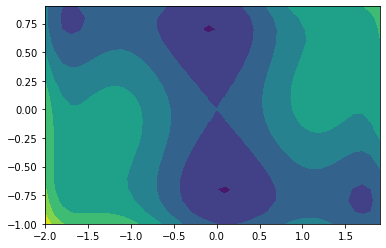

In [2]:
f = lambda x: (4 - 2.1*(x[0]**2) + (x[0]**4)/3) * (x[0]**2) + x[0]*x[1] + (4*(x[1]**2) - 4) * (x[1]**2)

x = np.arange(-2, 2, 0.1)
y = np.arange(-1, 1, 0.1)

x2, y2 = np.meshgrid(x, y, sparse=True)
z = f([x2, y2])

h = plt.contourf(x, y, z)
plt.show()

In [3]:
sol1 = optimize.minimize(f, [-2, -1])
sol2 = optimize.minimize(f, [2, 1])

# There are two global minima
print(f'Global minimum 1: ({sol1.x[0]}, {sol1.x[1]}) with value: {sol1.fun}')
print(f'Global minimum 2: ({sol2.x[0]}, {sol2.x[1]}) with value: {sol2.fun}')

sol3 = optimize.minimize(f, [0, 0])
print("solution 3: \n", sol3)
print("\n by using (0, 0) as an initial guess function avoids getting stuck at a saddle point and get their true global minima")

Global minimum 1: (0.08984183895244612, -0.712656281964251) with value: -1.03162845348966
Global minimum 2: (-0.08984185193837974, 0.7126562685092883) with value: -1.0316284534896496
solution 3: 
       fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])

 by using (0, 0) as an initial guess function avoids getting stuck at a saddle point and get their true global minima


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

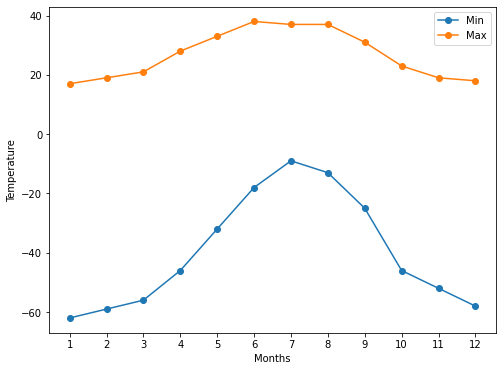

In [4]:
t_max = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
t_min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

months = np.arange(1, len(t_max) + 1)

fig, ax = plt.subplots( figsize=(8, 6))
ax.plot(months, t_min, label='Min', marker='o')
ax.plot(months, t_max, label='Max', marker='o')
ax.set_xlabel('Months')
ax.set_ylabel('Temperature')
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(1))


To fit max and min temperatures I use the gaussian function with a parameter b used as bias to move the function across the y axis 



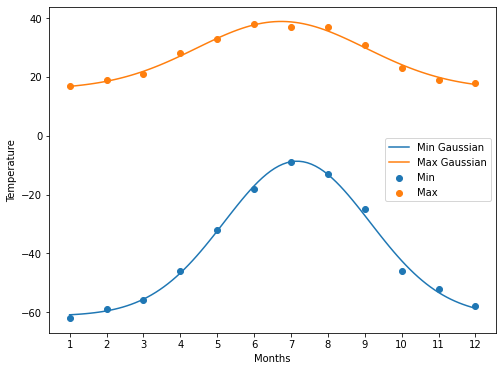

In [6]:
print("\nTo fit max and min temperatures I use the gaussian function with a parameter b used as bias to move the function across the y axis \n")
def gauss_weather(x,a,b,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b

param_max, _ = optimize.curve_fit(gauss_weather, months, t_max, full_output=False)
param_min, _ = optimize.curve_fit(gauss_weather, months, t_min, full_output=False)

fig, ax = plt.subplots( figsize=(8, 6))

x_plot = np.linspace(1, 12, 100)
ax.scatter(months, t_min, label='Min')
ax.plot(x_plot, gauss_weather(x_plot, param_min[0], param_min[1], param_min[2], param_min[3]), label='Min Gaussian')
ax.scatter(months, t_max, label='Max')
ax.plot(x_plot , gauss_weather(x_plot, param_max[0], param_max[1], param_max[2], param_max[3]), label='Max Gaussian')

ax.set_xlabel('Months')
ax.set_ylabel('Temperature')
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show()

In [9]:
offset_real_data = np.array(t_max) - np.array(t_min)
offset_fit = gauss_weather(months, param_max[0], param_max[1], param_max[2], param_max[3]) - gauss_weather(months, param_min[0], param_min[1], param_min[2], param_min[3])
offset = np.absolute(offset_real_data - offset_fit)

print(offset)
print("\nOffset between real data and the fitted data is low, we can conclude that obtained results are good.")

[1.29013896 0.11466269 0.5231322  0.15848809 0.5515393  1.22049305
 1.57269752 1.20673871 1.09194326 2.30839939 2.20466759 0.12561571]

Offset between real data and the fitted data is low, we can conclude that obtained results are good.


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [10]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
    
# retrieve data
data = pd.read_pickle("data/residuals_261.pkl")
df = pd.DataFrame(data.item(0))
display(df)

--2022-01-21 20:49:27--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2022-01-21 20:49:28--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc66bc2e3b2682794fb3911825ea.dl.dropboxusercontent.com/cd/0/inline/BeNYKZo7q0mKc5OXqfLTolDq62bAkAeqCu4t8ayZU6Qv0YUhE3uz0mYJDKmaGKn8AP6u8Xw9CpnToX8UqhXQOEPvZVKaRUSLewYSE9LSfTz1gQyqCwFGK5nXCe4Q_KU3NLa9rcjs6yaA5tTYljPQ-Uq8/file# [following]
--2022-01-21 20:49:28--  https://uc66bc2e3b2682794fb3911825ea.dl.dropboxusercontent.com/cd/0/inline/BeNYKZo7q0mKc5OXqfLTolDq62bAkAeqCu4t8ayZU6Qv0YUhE3uz0mYJDKmaGKn8AP6u8Xw9

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


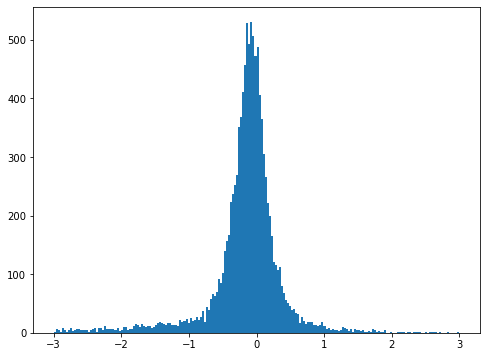

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
n_bin = 200
h, bins, _ = ax.hist(df['residuals'], bins=n_bin, range = (-3, 3), density=False, cumulative=False)
bin_centers = (bins[1:] + bins[:-1]) / 2

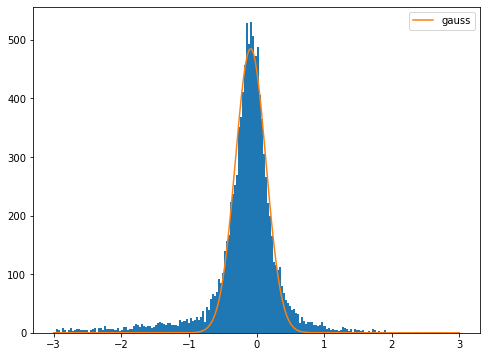

In [16]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

param1, _ = optimize.curve_fit(gauss, bin_centers, h, full_output=False)

fig, ax = plt.subplots(figsize=(8, 6))
h, bins, _ = ax.hist(df['residuals'], bins=n_bin, range = (-3, 3), density=False, cumulative=False)

x_plot = np.linspace(-3, 3 , 200)
ax.plot(x_plot, gauss(x_plot, param1[0], param1[1], param1[2]), label="gauss")
ax.legend()

In [18]:
ssr = np.sum((h - gauss(bin_centers, param1[0], param1[1], param1[2]))**2)
tss = np.sum((np.mean(h) - h)**2)
rsq = 1 - ssr / tss

print("GAUSS: R2 =", rsq, "\nR =", sqrt(rsq))

GAUSS: R2 = 0.9787624324264369 
R = 0.9893242301826216


In [21]:
ndof = n_bin - 1
y_err = np.sqrt(h)

print("n degrees of freedom =", ndof)

chi2 = np.sum(((h - gauss(bin_centers, param1[0], param1[1], param1[2]))**2) / y_err)
print("chi2 =", chi2)

pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)

n degrees of freedom = 199
chi2 = inf
p-value = 0.0


<ipython-input-21-6806ed172cd9>:6: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(((h - gauss(bin_centers, param1[0], param1[1], param1[2]))**2) / y_err)


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [22]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P data/
df = pd.read_csv("data/munich_temperatures_average_with_bad_data.txt", delimiter=" ", names=['Date', 'Temperature'])

mask = (df['Date']>=2008) & (df['Date']<=2012)
df = df[mask]
# remove noisy measurements
df = df[df['Temperature'] < 50]

display (df)

--2022-01-21 20:55:03--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [following]
--2022-01-21 20:55:04--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdbd2242403f009cb9c11acd195.dl.dropboxusercontent.com/cd/0/inline/BeNpkkACF7Hz-gRXesXepxWcAeF51LOBV7dw44FCWC_ibtLz11j4XZFmUfubg4E4pLAxqA5KIkxegrGeM_MLzOGpVX2A2Desk7SMWCI_hWwGtBCYg7dLg8VYD70Ur7Ps3w5L6AsZcv6brycjsGGs1B_A/file# [following]
--2022-01-21 20:55:04--  https://ucdbd2242403f009cb9c11acd195.dl.dropboxusercontent.com/

,Date,Temperature
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


Best values are: 

a =  -9.96203467789479
b =  12.331742857750834
c =  9.262821311360776

Overall average temperature :  9.261252084167236
Coldest fitted temperature :  15.595983907207788
Hottest fitted temperature :  2.9004155965954


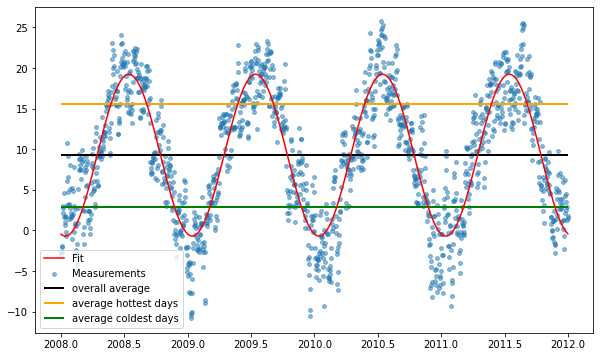

In [23]:
f = lambda t, a, b, c: a * np.cos(2 * pi * t + b) + c 

param1, _ = optimize.curve_fit(f, df['Date'], df['Temperature'], full_output=False)

print("Best values are: \n")
print("a = ", param1[0])
print("b = ", param1[1])
print("c = ", param1[2])


t_avg = df["Temperature"].mean()
print("\nOverall average temperature : ", t_avg)

t_fitted = f(df['Date'], param1[0], param1[1], param1[2])
t_coldest = t_fitted[t_fitted > t_avg].mean()
t_hottest = t_fitted[t_fitted < t_avg].mean()
print("Coldest fitted temperature : ", t_coldest)
print("Hottest fitted temperature : ", t_hottest)


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['Date'], df['Temperature'], label='Measurements', alpha=0.5, s=15)
ax.plot(df['Date'], f(df['Date'], param1[0], param1[1], param1[2]), label='Fit', c='red')
ax.hlines(y = t_avg, xmin=2008, xmax=2012, linewidth=2, color ='black', label ="overall average")
ax.hlines(y = t_coldest, xmin=2008, xmax=2012, linewidth=2, color ='orange', label ="average hottest days")
ax.hlines(y = t_hottest, xmin=2008, xmax=2012, linewidth=2, color ='green', label ="average coldest days")
ax.legend()


The b parameter let the function shift along the x axis.
This permits to adjust the correct shape with respect to Date.


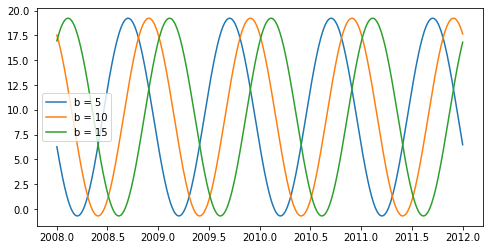

In [24]:
print("The b parameter let the function shift along the x axis.")
print("This permits to adjust the correct shape with respect to Date.")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df['Date'], f(df['Date'], param1[0], 5, param1[2]), label='b = 5')
ax.plot(df['Date'], f(df['Date'], param1[0], 10, param1[2]), label='b = 10')
ax.plot(df['Date'], f(df['Date'], param1[0], 15, param1[2]), label='b = 15' )
ax.legend()

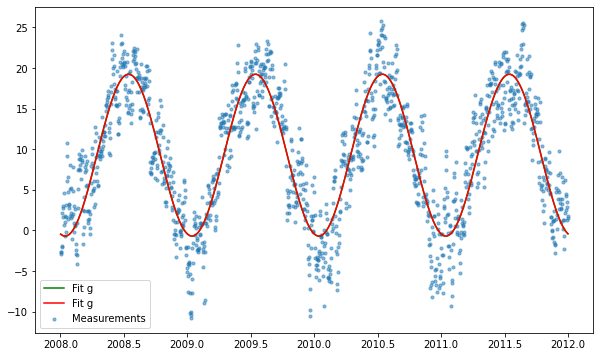

In [25]:
g = lambda t, a, b, c, d: a * np.cos(2 * pi * b * t + c) + d

param_g, _ = optimize.curve_fit(g, df['Date'], df['Temperature'], full_output=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['Date'], df['Temperature'], label='Measurements', alpha=0.5, s=10)
ax.plot(df['Date'], f(df['Date'], param1[0], param1[1], param1[2]), label='Fit g', c='green')
ax.plot(df['Date'], g(df['Date'], param_g[0], param_g[1], param_g[2], param_g[3]), label='Fit g', c='red')
ax.legend()

In [27]:
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

ssr_f = np.sum((df['Temperature'] - f(df['Date'], param1[0], param1[1], param1[2]))**2)
ssr_g = np.sum((df['Temperature'] - g(df['Date'], param_g[0], param_g[1], param_g[2], param_g[3]))**2)

print("SSR f : ", ssr_f)
print("SSR g : ", ssr_g)

print("\nTest f(3 parameters) vs g(4 parameters):")
cl_3_vs_4 = Ftest(ssr_f, ssr_g, 3, 4, len(df['Temperature']), verbose=True)

SSR f :  18669.51539457836
SSR g :  18669.225430686973

Test f(3 parameters) vs g(4 parameters):
CL: 0.881 , additional parameter necessary: NO
